In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, colorbar
import pandas as pd
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import PIL
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 # generate the groudtruth data
# y = sum_{k=1}^K a0k conv x0k + b*1 + n
# s = rng(seed)
def gen_data_2D(theta, x_grid, n, b, noise_level, a_type,x_type, raw_data_handeling = None):
    """
    Parameters:
    ----------------
    theta: the threshold for generating spike train X_0
    x_grid: a length 2 list denoting the grid dimension for X
    n: the dimension of the kernel (we use squared kernel)
    b: the magnitude of the bias term
    noise_level: the magnitude of noise
    a_type: the kernel type we want to apply on X (randn, 2d-gaussian, sinc)
    x_type: which method we want to generate x_0 (bernoulli, bernoulli-gaussian)
    raw_data_handeling: our generated X may have some entry as negative values,
                        however, this will not happen in real image, so we need
                        to take care of those negative entries. (max_0, sigmoid)
    """
    
    # generate the kernel a_0
    gamma = [1.7, -0.712] # Parameter for AR2 model
    t = np.linspace(0, 1, n**2).reshape([n, n]) 
    case = a_type.lower()
    if case == "randn": # Random Gaussian
        a_0 = np.random.normal(size = [n, n])
    elif case == "sinc":
        sigma = 0.05
        a_0 = np.sinc((t-0.5)/sigma)
    elif case == "2d-gaussian":
        sigma = 0.5 # could perturb sigma if you want
        # 2D gaussian kernel
        grid_hori = np.linspace(-n / 2, n / 2, n)
        grid_verti = grid_hori.copy()
        mesh_x, mesh_y = np.meshgrid(grid_hori, grid_verti)
        a_0 = 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(mesh_x ** 2 + mesh_y ** 2) / 2 * sigma ** 2)
    else:
        raise ValueError("Wrong type")

    #a_0 = a_0 / np.linalg.norm(a_0, axis = 0)  # Normalize kernel by column
    a_0 = a_0 / np.max(np.linalg.eig(a_0)[0])

    # Generate the spike train x_0
    m_0, m_1 = x_grid
    case_x = x_type.lower()
    if case_x == "bernoulli":
        x_0 = (np.random.uniform(size = [m_0, m_1]) <= theta).astype(int) # Bernoulli spike train
    elif case_x == 'bernoulli-gaussian':
        # Gaussian-Bernoulli spike train
        x_0 = np.random.normal(size = [m_0, m_1]) * (np.random.uniform(size = [m_0, m_1]) <= theta)
    else:
        raise ValueError("Wrong type")
    # Now handle negative entries
    if case_x != "bernoulli":
        case_handle = raw_data_handeling.lower()
        if case_handle == "max_0":
            x_0 = np.maximum(x_0, 0)
        elif case_handle == "sigmoid":
            indices = (x_0 < 0)
            x_0[indices] = 1 / (1 + np.exp(-x_0[indices])) 

    # generate the data y = a_0 conv b_0 + bias + noise
    ##### Circular convolution alert
    y_0 = cconv(a_0, x_0, [m_0, m_1]) + b * np.ones([m_0,m_1])
    y = y_0 + np.random.normal(size = [m_0, m_1]) * noise_level
        
    return [a_0, x_0, y_0, y]

def ar2exp(g):
    # get parameters of the convolution kernel for AR2 process
    # Dependency of gen_data
    if len(g) == 1:
        g.append(0)
    temp = np.roots([1, -g[0], -g[1]]) # Polynomial roots
    d = np.max(temp)
    r = np.min(temp)
    tau_d = -1 / np.log(d)
    tau_r = -1 / np.log(r)

    tau_dr = [tau_d, tau_r]
    return np.array(tau_dr)

def cconv(mat1, mat2, output_shape):
    # Since there's a lot of functions use circular function
    # and python doesn't have a function for that
    # Dependency of gen_data
    
    return np.real((np.fft.ifft2(np.fft.fft2(mat1, s = output_shape) \
                        * np.fft.fft2(mat2, s = output_shape))))

In [ ]:
x=[]
y1=[]
for i in range(2000):
  for j in ["randn", "2d-gaussian", "sinc"]:
    for k in ["bernoulli", "bernoulli-gaussian"]:
      [a_0, x_0, y_0, y] = gen_data_2D(0.02, [64,64], 3, 0.3, 0.1, j,k, 'sigmoid')
      x.append(x_0)
      y1.append(y_0)
data=pd.DataFrame([x,y1]).T

In [ ]:
x_dev=[]
y1_dev=[]
for i in range(500):
  for j in ["randn", "2d-gaussian", "sinc"]:
    for k in ["bernoulli", "bernoulli-gaussian"]:
      [a_0, x_0, y_0, y] = gen_data_2D(0.02, [64,64], 3, 0.3, 0.1, j,k, 'sigmoid')
      x_dev.append(x_0)
      y1_dev.append(y_0)
validation=pd.DataFrame([x_dev,y1_dev]).T

In [ ]:
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            y = self.map(self.dataset[0][index]).float()
            x = self.map(self.dataset[1][index]).float()
        else:     
            y = self.dataset[0][index]
            x = self.dataset[1][index]     
        return x, y

    def __len__(self):
        return len(self.dataset)

In [ ]:
test_transform = transforms.Compose([
                                     transforms.ToTensor()
                                     
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor()
                                      
                                      ])

In [ ]:
train_dataset_w_transform  = MapDataset(data, train_transform)
val_dataset_w_transform = MapDataset(validation, test_transform)
# test_dataset_w_transform = MapDataset(test_dataset, test_transform)

bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
# test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
loader={'train':train_loader,'val':val_loader}

In [ ]:
import torch
from torch.autograd import Variable


class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(1, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

# # check keras-like model summary using torchsummary
# from torchsummary import summary
# summary(model, input_size=(3, 224, 224))

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25,dataloaders=loader):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts,'./best.pt')

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6
model = UNet().to(device)

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

cuda:0
Epoch 0/59
----------
LR 0.0001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functi

train: bce: 0.500527, dice: 0.968091, loss: 0.734309
val: bce: 0.652479, dice: 0.967541, loss: 0.810010
saving best model
0m 33s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.430288, dice: 0.965927, loss: 0.698108
val: bce: 0.418021, dice: 0.967494, loss: 0.692757
saving best model
0m 27s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.406183, dice: 0.964042, loss: 0.685113
val: bce: 0.614219, dice: 0.962967, loss: 0.788593
0m 26s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.384189, dice: 0.962440, loss: 0.673315
val: bce: 0.418451, dice: 0.962056, loss: 0.690253
saving best model
0m 28s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.362060, dice: 0.960164, loss: 0.661112
val: bce: 0.356384, dice: 0.962218, loss: 0.659301
saving best model
0m 28s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.340431, dice: 0.957191, loss: 0.648811
val: bce: 0.341881, dice: 0.967084, loss: 0.654483
saving best model
0m 28s
Epoch 6/59
----------
LR 0.0001
train: bce: 0.321466, dice: 0.948963, loss: 0.635214

In [ ]:
best_model = UNet().to(device)
best_model.load_state_dict(torch.load("./best.pt"))
best_model.eval()

UNet(
  (down_block1): UNet_down_block(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block2): UNet_down_block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

In [ ]:
for i,(inputs, labels) in enumerate(loader["train"]):
    inputs = inputs.to(device)
    print(inputs.size())
    labels = labels.to(device)
    outputs = best_model(inputs)
    print(outputs.size())
    break


torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
y0 = inputs.squeeze(1)[0]
x0 = labels.squeeze(1)[0]

pred = outputs.squeeze(1)[0]

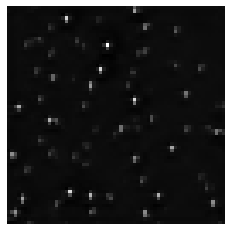

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(pred.cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

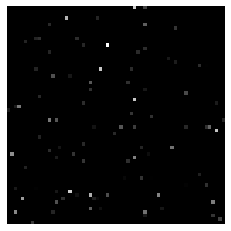

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x0.cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

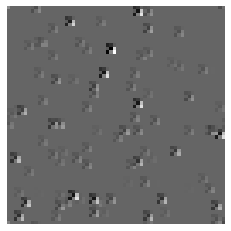

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(y0.cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
pred

tensor([[-1.8425, -1.8752, -1.8720,  ..., -1.7861, -1.8368, -1.7269],
        [-1.6660, -1.9266, -1.9458,  ..., -1.8800, -1.8135, -1.8371],
        [-1.8728, -1.9701, -1.8852,  ..., -1.8294, -1.8619, -1.8332],
        ...,
        [-1.7237, -1.8081,  0.7162,  ..., -1.8662, -1.9674, -1.9427],
        [-1.3176, -1.5571, -1.7688,  ..., -1.8318, -1.9595, -1.9241],
        [-1.9866, -2.1171, -2.0776,  ..., -1.7336, -1.2480, -1.7764]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
x0

tensor([[-0.0000, 0.0000, 0.0000,  ..., -0.0000, -0.0000, 0.0000],
        [0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, 0.0000],
        [0.0000, -0.0000, -0.0000,  ..., -0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, 0.0000],
        [0.0000, -0.0000, -0.0000,  ..., 0.0000, 0.5922, -0.0000],
        [0.0000, -0.0000, -0.0000,  ..., 0.0000, -0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
y0

tensor([[ 0.8095,  0.3000,  0.3000,  ...,  0.3000, -0.0164,  0.4017],
        [ 0.3000,  0.3000,  0.3000,  ...,  0.3000,  0.3000,  0.3000],
        [ 0.3000,  0.3000,  0.3000,  ...,  0.3000,  0.3000,  0.3000],
        ...,
        [ 0.3000,  0.3000,  0.2111,  ...,  0.1573,  0.2746,  0.3000],
        [ 0.2683,  0.3000, -0.3519,  ...,  0.0314,  0.3707,  0.1216],
        [ 0.6792,  0.3000,  0.3000,  ...,  0.3814,  0.6645, -0.0356]],
       device='cuda:0')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


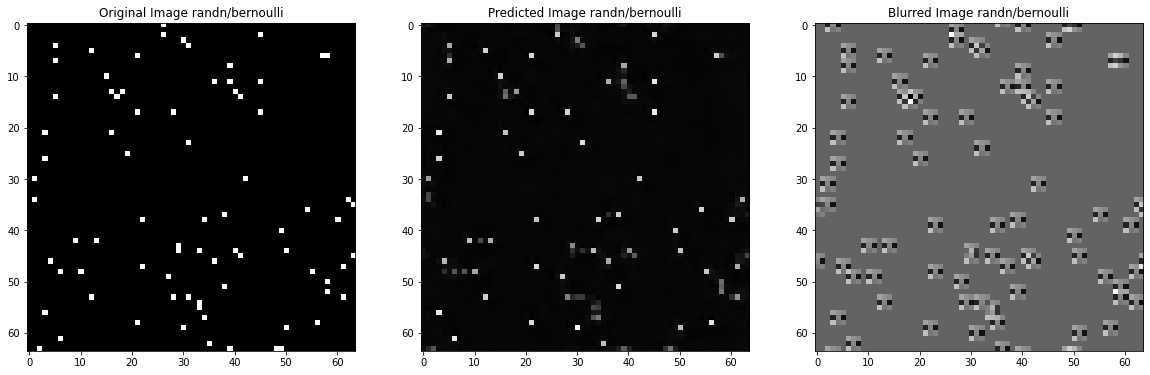

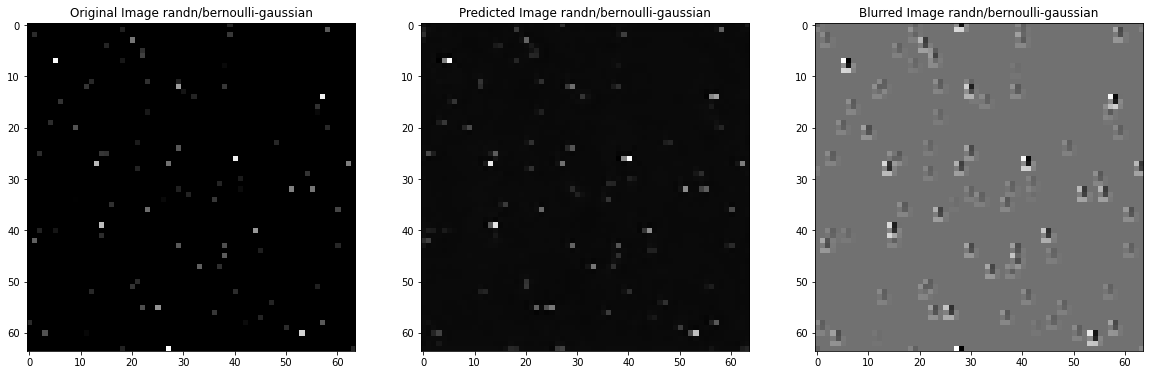

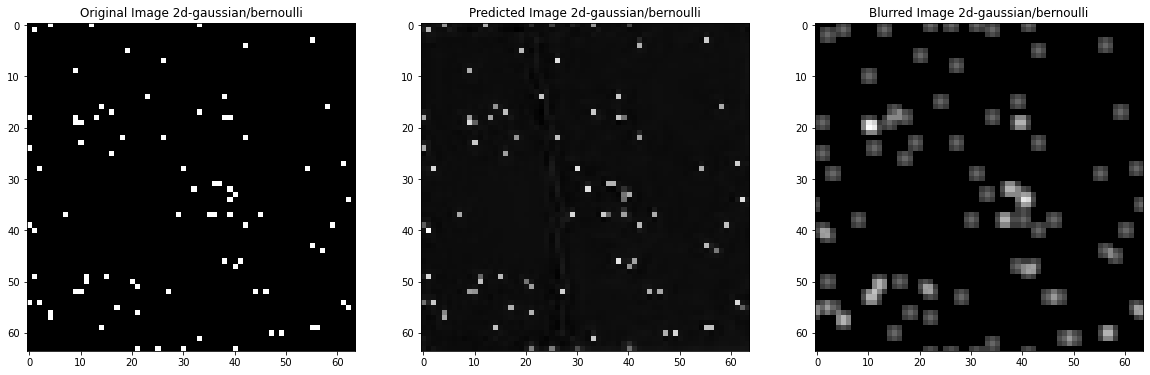

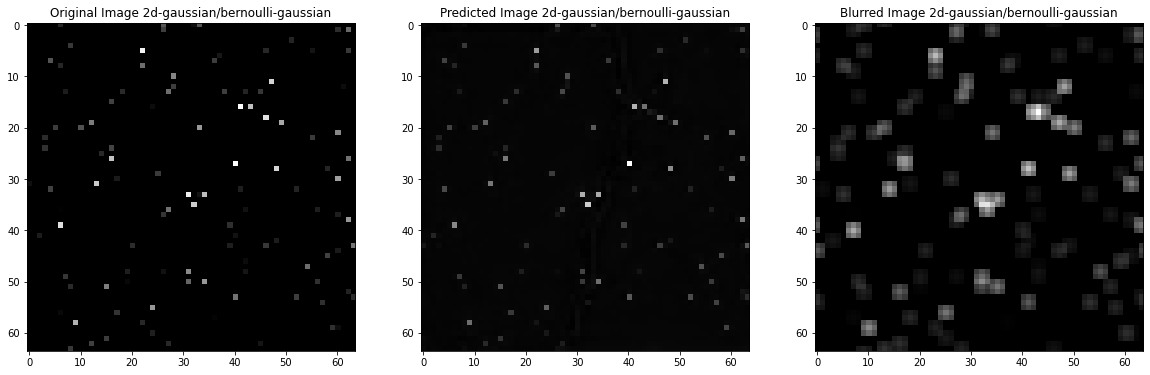

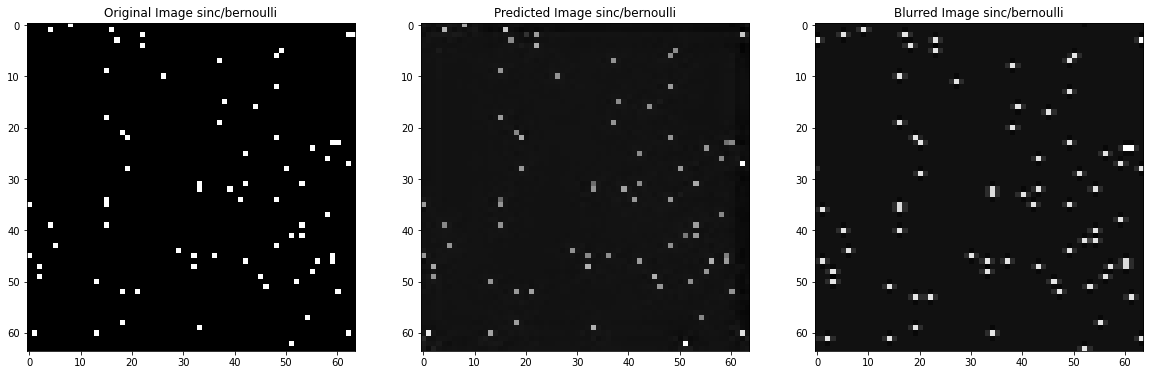

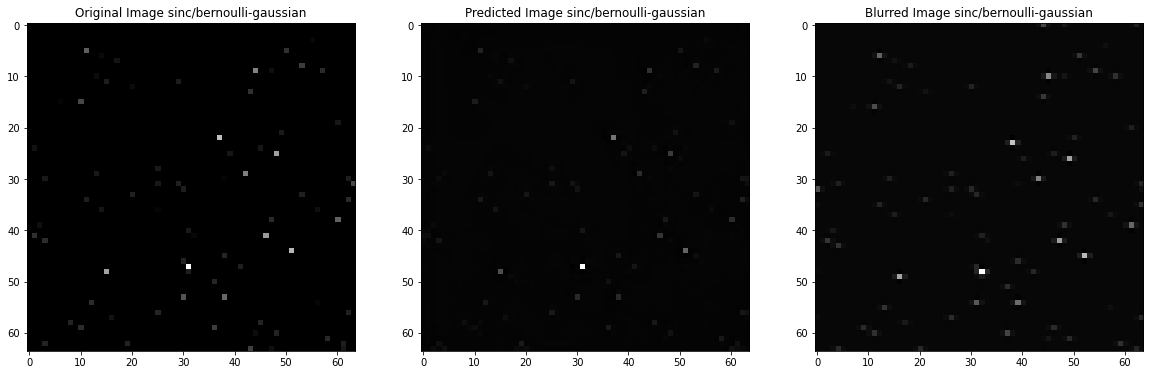

In [ ]:
x=[]
y1=[]
#fig, axs = plt.subplots(18)
for i in range(1):
  for j in ["randn", "2d-gaussian", "sinc"]:
    for k in ["bernoulli", "bernoulli-gaussian"]:
      [a_0, x_0, y_0, y] = gen_data_2D(0.02, [64,64], 3, 0.3, 0.1, j,k, 'sigmoid')
      inputs = transforms.ToTensor()(y_0).float().to(device)
      #inputs=inputs.to(device)
      #print(torch.unsqueeze(inputs,1).size())
      labels =  transforms.ToTensor()(x_0).to(device)
      outputs = best_model(torch.unsqueeze(inputs,1))
      plt.figure(figsize=(20,20))
      plt.subplot(131)
      plt.title('Original Image {}/{}'.format(j,k))
      plt.imshow(x_0,cmap='gray')
      #plt.figure(figsize=(8,8))
      plt.subplot(132)
      plt.title('Predicted Image {}/{}'.format(j,k))
      pred=outputs.squeeze(1)[0]
      plt.imshow(pred.cpu().detach().numpy(),cmap='gray')
      #plt.figure(figsize=(8,8))
      plt.subplot(133)
      plt.title('Blurred Image {}/{}'.format(j,k))
      plt.imshow(y_0,cmap='gray')
